# DataGen

In [1]:
# Main
from DataGenerator import DataGenerator

BATCH_SIZE=10
IMG_SIZE=512

train_gen = DataGenerator('./TrainData', BATCH_SIZE, IMG_SIZE, aug=True)
test_gen = DataGenerator('./TestData', BATCH_SIZE, IMG_SIZE, aug=False)

# Build modle

In [7]:
import tensorflow as tf
import keras
from keras import backend as K
from BuildModel import build_model

def loss_function(y_true, y_pred):
  squared_diff = tf.square(y_true - y_pred)
  return tf.reduce_mean(squared_diff)
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss




K.clear_session()

opt = keras.optimizers.Adam(learning_rate=1e-3)
#loss_function

model = build_model(IMG_SIZE)

# validation_split = 0.1, callbacks=[mc, rl, es]
# model = create_model()
# model.load_weights('/content/drive/Shareddrives/生物傳輸/data/simple_weights_8.h5')
model.compile(optimizer=opt,loss=bce_dice_loss,metrics=[dice_coef])
#model.summary()


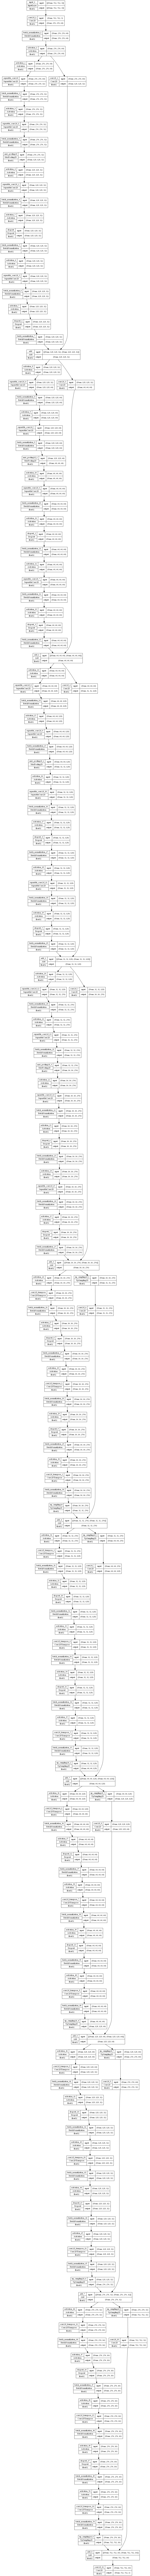

In [8]:
from keras.utils import to_categorical, plot_model

plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True)

In [4]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mc = ModelCheckpoint(filepath= '/content/drive/Shareddrives/機器學習final/model/unet_weights_4.h5', monitor='val_dice_coef', mode='max', save_best_only=True,save_weights_only=True)
rl = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=8)
es = EarlyStopping(monitor='val_loss', mode='min', patience=15)
# tb = TensorBoard(log_dir=model_dir)
callbacks_list = [mc, rl, es]

model.fit(train_gen,
          validation_data = test_gen,
          batch_size=12, epochs=40,
          validation_split = 0.1, callbacks=[mc, rl, es])

TypeError: '>' not supported between instances of 'list' and 'int'